<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the final aeroplane we will progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*In the following text, we investigate how ADRpy can be used to consolidate design constraints on the required performance a propulsion system to be installed.*

# Constraint Analysis of a Single Engine Piston Prop

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

## Demonstration of Manual Analysis

First, we set up a dictionary variable containing elements of the design brief. All of the requirements below refer to ISA standard day conditions (see the documentation for the ``Atmosphere`` class for how to instantiate other atmospheres). The dictionary entry ``cruisethrustfact`` defines the throttle setting expected to be used in cruise (1 = full throttle).

In [2]:
designbrief = {'rwyelevation_m':0, 'groundrun_m':313, # <- Take-off requirements
               'stloadfactor': 1.5, 'turnalt_m': 1000, 'turnspeed_ktas': 100, # <- Turn requirements
               'climbalt_m': 0, 'climbspeed_kias': 101, 'climbrate_fpm': 1398, # <- Climb requirements
               'cruisealt_m': 3048, 'cruisespeed_ktas': 182, 'cruisethrustfact': 1.0, # <- Cruise requirements
               'servceil_m': 6580, 'secclimbspd_kias': 92, # <- Service ceiling requirements
               'vstallclean_kcas': 69} # <- Required clean stall speed

Some constraints may not have to be satisfied at MTOW - ``wfract`` specifies the weight fraction corresponding to each constraint:

In [3]:
wfract = {'turn': 1.0, 'climb': 1.0, 'cruise': 0.853, 'servceil': 1.0}

These fractions, as well as some basic design parameters are specified in the ``designdefinition`` dictionary: aspect ratio, leading edge sweep, sweep of the maximum thickness line of the wing, the engine bypass ratio ('-1' indicates 'piston engine'), and an initial estimate of the take-off weight:

In [4]:
TOW_kg = 1542.0

designdefinition = {'aspectratio':10.12, 'sweep_le_deg':2, 'sweep_mt_deg':0, 'bpr':-1, 'weightfractions':wfract,
                    'weight_n': TOW_kg * 9.81} 

We next define some design performance estimates, e.g., the propeller efficiencies ($\eta_\mathrm{prop}$) corresponding to the various constraints, drag and lift coefficients and the wheel rolling resistance coefficient:

In [5]:
etap = {'take-off': 0.65, 'climb': 0.8, 'cruise': 0.85, 'turn': 0.85, 'servceil': 0.8}

designperformance = {'CDTO':0.0414, 'CLTO':0.59, 'CLmaxTO':1.69, 'CLmaxclean': 1.45, 'mu_R':0.02, 
                     'CDminclean':0.0254, 'etaprop': etap}

Define the atmosphere in which the calculations are to be conducted - in this case the International Standard Atmosphere. Other atmospheres available in the ``Atmospheres`` class: off-standard ISAs, MIL-HDBK-310 and bespoke atmospheres.

In [6]:
designatm = at.Atmosphere()

We are now ready to instantiate the aircraft concept object:

In [7]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm)

We define a range of wing loadings for which we want to compute the required power:

In [8]:
wingloadinglist_pa = np.arange(700, 2500, 5)

And the main event: we call the power calculation method, as well as the method for calculating the minimum area dictated by the stall requirement:

In [9]:
preq = concept.powerrequired(wingloadinglist_pa, TOW_kg) 

Smin_m2 = concept.smincleanstall_m2(TOW_kg)

We can now generate a plot of the various constraint curves in the power versus wing area space:

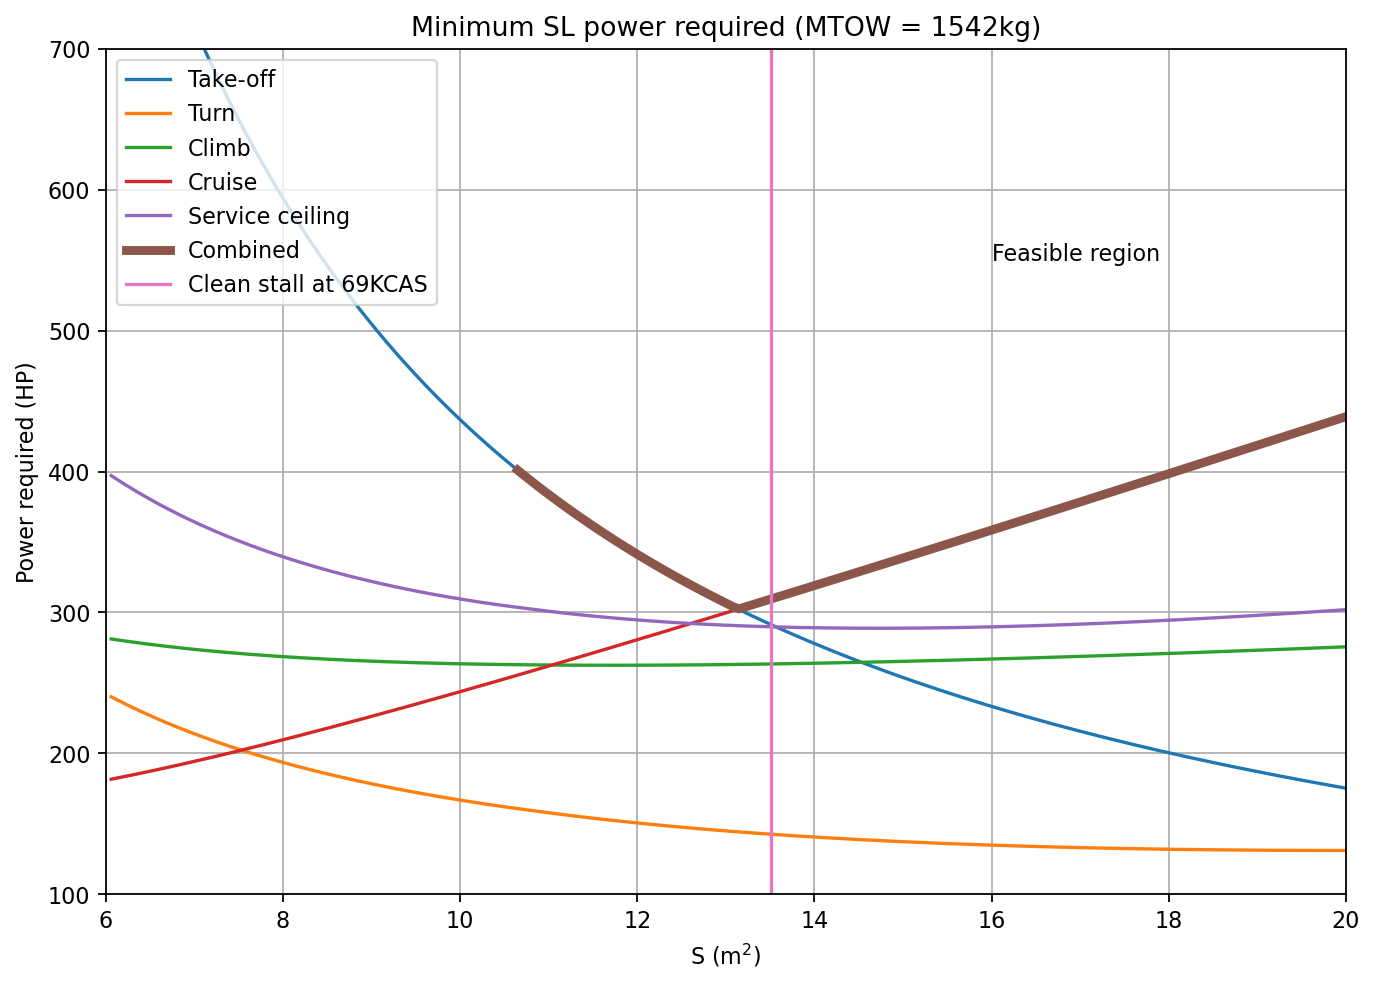

In [10]:
wingarea_m2 = co.kg2n(TOW_kg) / wingloadinglist_pa # x axis

plt.rcParams["figure.figsize"] = [10,7]
plt.rcParams['figure.dpi'] = 160

plt.plot(wingarea_m2, preq['take-off'],  label = 'Take-off')
plt.plot(wingarea_m2, preq['turn'], label = 'Turn')
plt.plot(wingarea_m2, preq['climb'], label = 'Climb')
plt.plot(wingarea_m2, preq['cruise'], label = 'Cruise')
plt.plot(wingarea_m2, preq['servceil'], label = 'Service ceiling')
combplot = plt.plot(wingarea_m2, preq['combined'], label = 'Combined')
plt.setp(combplot, linewidth=4)
stall_label = 'Clean stall at ' + str(designbrief['vstallclean_kcas']) + 'KCAS'
plt.plot([Smin_m2, Smin_m2], [0, 1500], label = stall_label)
legend = plt.legend(loc='upper left')
plt.ylabel("Power required (HP)")
plt.xlabel("S (m$^2$)")
plt.title("Minimum SL power required (MTOW = " + str(round(TOW_kg)) + "kg)")
plt.xlim(6, 20)
plt.ylim(100, 700)
plt.grid(True)
plt.text(16, 550, 'Feasible region')
plt.show()

From the above plot we can immediately see that the design is bounded by the minimum wing area as given by the clean-stall speed at sea-level, and the cruise constraint. We may choose to minimise the power required of a propulsion solution by either increasing $V_{stall}$ for the sea-level stall requirement, or by altering the cruise requirements of the aircraft as specified in the design brief.

An advantage of plotting in this manner, is that any number of constraints on the design may be added or removed from the plot to improve clarity, or increase flexibility of the concept. For example it may be prudent to add a limit to the maximum wing-area given aspect and taper ratios, such that the aircraft wingspan does not exceed limits as imposed by hangar size.

## Sensitivity Analysis Methods

The purpose of sensitivity analysis is to investigate to what design parameters an aircraft concept's constraints are most sensitive to changes in. With these tools, we can investigate the importance of cruising altitude, sweep angle, and bypass ratio amongst other design parameters, to the cruise propulsion constraint for example.

A design parameter can be investigated by replacing its float/integer value with a list containing maximum and minimum design values. The nominal, baseline value for a parameter is taken as an average of the list's contents. See the below example, which describes this concept:

In [11]:
old_designbrief = {'rwyelevation_m':0, 'groundrun_m':313}

# Sensitivity analysis methods parse the above data as the following:

# rwyelevation_m:
#     max = 0;
#     avg = 0 (nominal, baseline value);
#     min = 0;
# groundrun_m:
#     max = 313;
#     avg = 313 (nominal, baseline value);
#     min = 313;

The provided parameters in `old_designbrief` are integers/floats, and are fixed design points. The module will automatically ignore fixed design points with regards to performing any sensitivity analysis operations. One may find that the take-off ground roll parameters are fixed as the result of a limiting requirement to take-off from a very particular runway, for example.

Let's now take a look at the kind of design brief the sensitivity methods are expecting to encounter.

In [12]:
new_designbrief = {'rwyelevation_m':[-100, 120], 'groundrun_m':[280, 310, 310]}

# Sensitivity analysis methods parse the above data as the following:

# rwyelevation_m:
#     max = 120;
#     avg = 10 (nominal, baseline value);
#     min = -100
# groundrun_m:
#     max = 310;
#     avg = 300 (nominal, baseline value);
#     min = 280;

Now we understand what the methods are looking for, let's build our aircraft concept's design dictionaries. Note that in the example that follows, parameters in the design brief relating to the take-off requirements are taken as fixed design points, whereas the requirements for cruise are not fixed. Also note the inclusion of aspect ratio and the zero-lift drag coefficient (CDminclean) in the sensitivity analysis.

In [13]:
designbrief = {'rwyelevation_m': 0, 'groundrun_m': 313,
                'stloadfactor': [1.5, 1.65], 'turnalt_m': [1000, 1075], 'turnspeed_ktas': [100, 110],
                'climbalt_m': 0, 'climbspeed_kias': 101, 'climbrate_fpm': 1398,
                'cruisealt_m': [2600, 3200], 'cruisespeed_ktas': [170, 175], 'cruisethrustfact': 1.0,
                'servceil_m': [6500, 6650], 'secclimbspd_kias': 92,
                'vstallclean_kcas': 69}

designdefinition = {'aspectratio': [10, 11], 'sweep_le_deg': 2, 'sweep_25_deg': 0, 'bpr': -1,
                    'weight_n': 15000,
                    'weightfractions': {'turn': 1.0, 'climb': 1.0, 'cruise': 0.853, 'servceil': 1.0}}

designperformance = {'CDTO': 0.0414, 'CLTO': 0.59, 'CLmaxTO': 1.69, 'CLmaxclean': 1.45, 'mu_R': 0.02,
                    'CDminclean': [0.0254, 0.026],
                    'etaprop': {'take-off': 0.65, 'climb': 0.8, 'cruise': 0.85, 'turn': 0.85, 'servceil': 0.8}}

designatm = at.Atmosphere()

In [14]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm)
wslist_pa = np.arange(700, 2500, 2.5)

This new aircraft concept is similar to, but nevertheless very slightly differs from the concept given in **Demonstration of Manual Analysis**.

#### One-Factor-at-a-Time Sensitivity, w/ Worked Example

This section demonstrates how the `propulsionsensitivity_monothetic` method can assist designers in understanding how constraints impact the propulsion system requirements. As the section header suggests, this method alters selected design parameters one-factor-at-a-time (OFAT/OAT) to investigate their impact on propulsion constraints, whilst other variables maintain nominal values. An advantage of this approach is the low computational effort required to process the method, however this type of analysis fails to capture the combined effect of changing multiple design parameters at once. See the documentation for the full list of arguments this method can interpret.

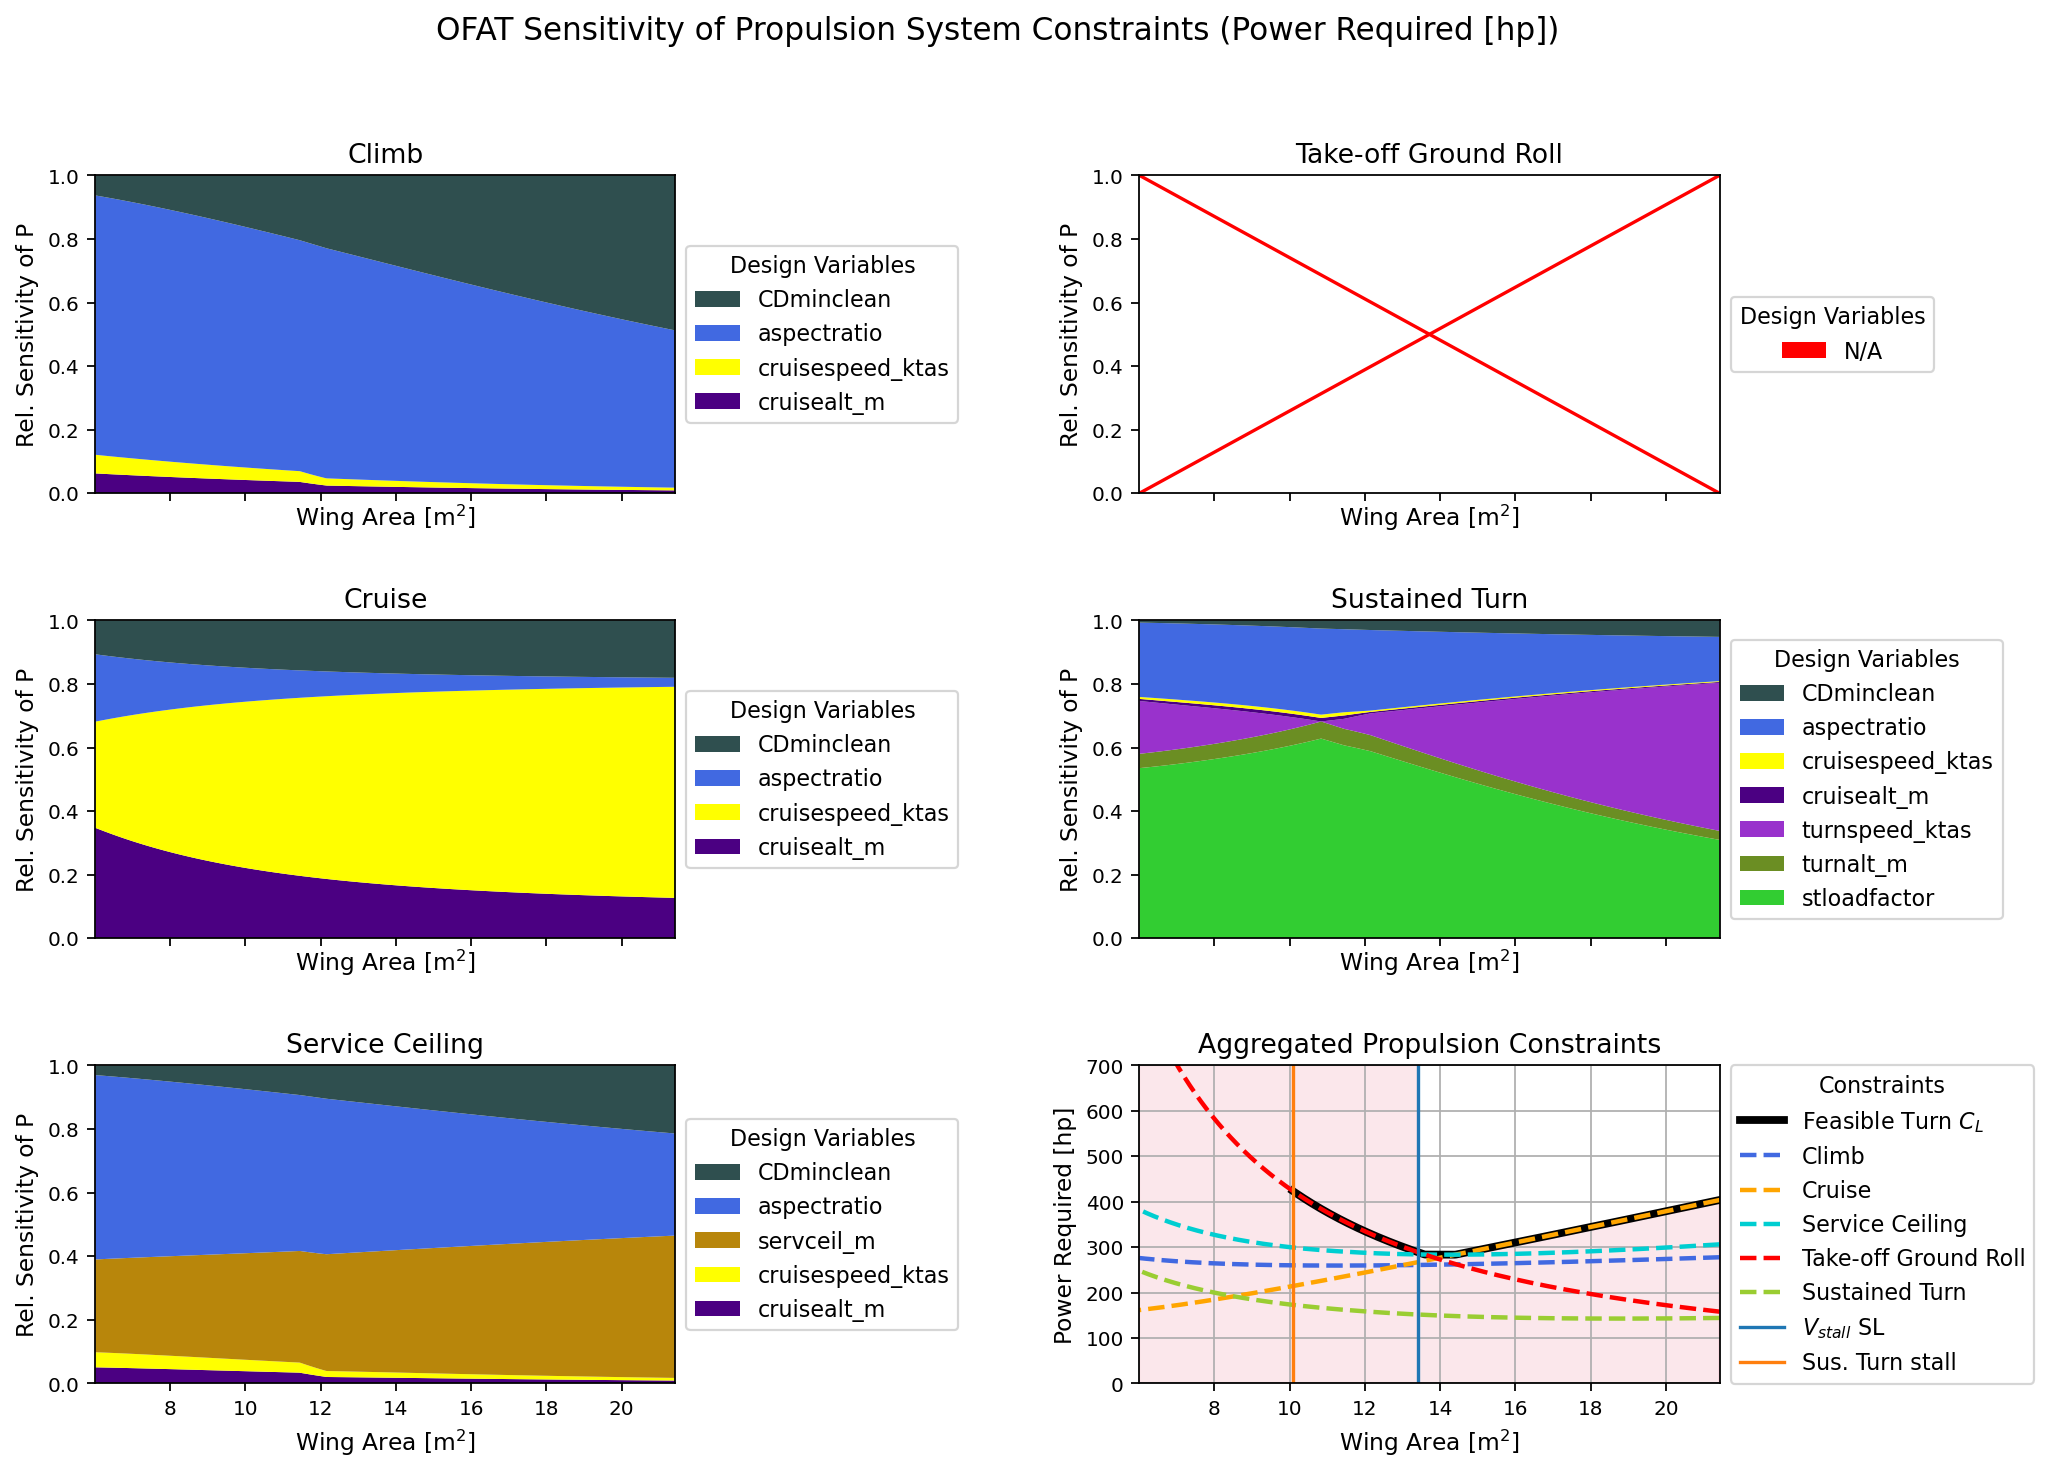

In [15]:
concept.propulsionsensitivity_monothetic(wingloading_pa=wslist_pa, show=True, y_var='p_hp', x_var='s_m2', y_lim=700)

With regards to the example parameters we've elected to investigate the sensitivity of, note that the sustained turn constraint is very weakly a function of the cruise design parameters! As far as the performance models are concerned, this is because the propulsion constraints are functions of the induced drag as calculated by the leading-edge suction method (see Estimating the Induced Drag Factor with ADRpy for more information). No parameter being investigated was ultimately responsible for any changes in the Take-off ground roll constraint, and therefore the plot does not display any sensitivity data.

Let's take a closer look at the combined constraint plot, by using the `show='combined'` argument:

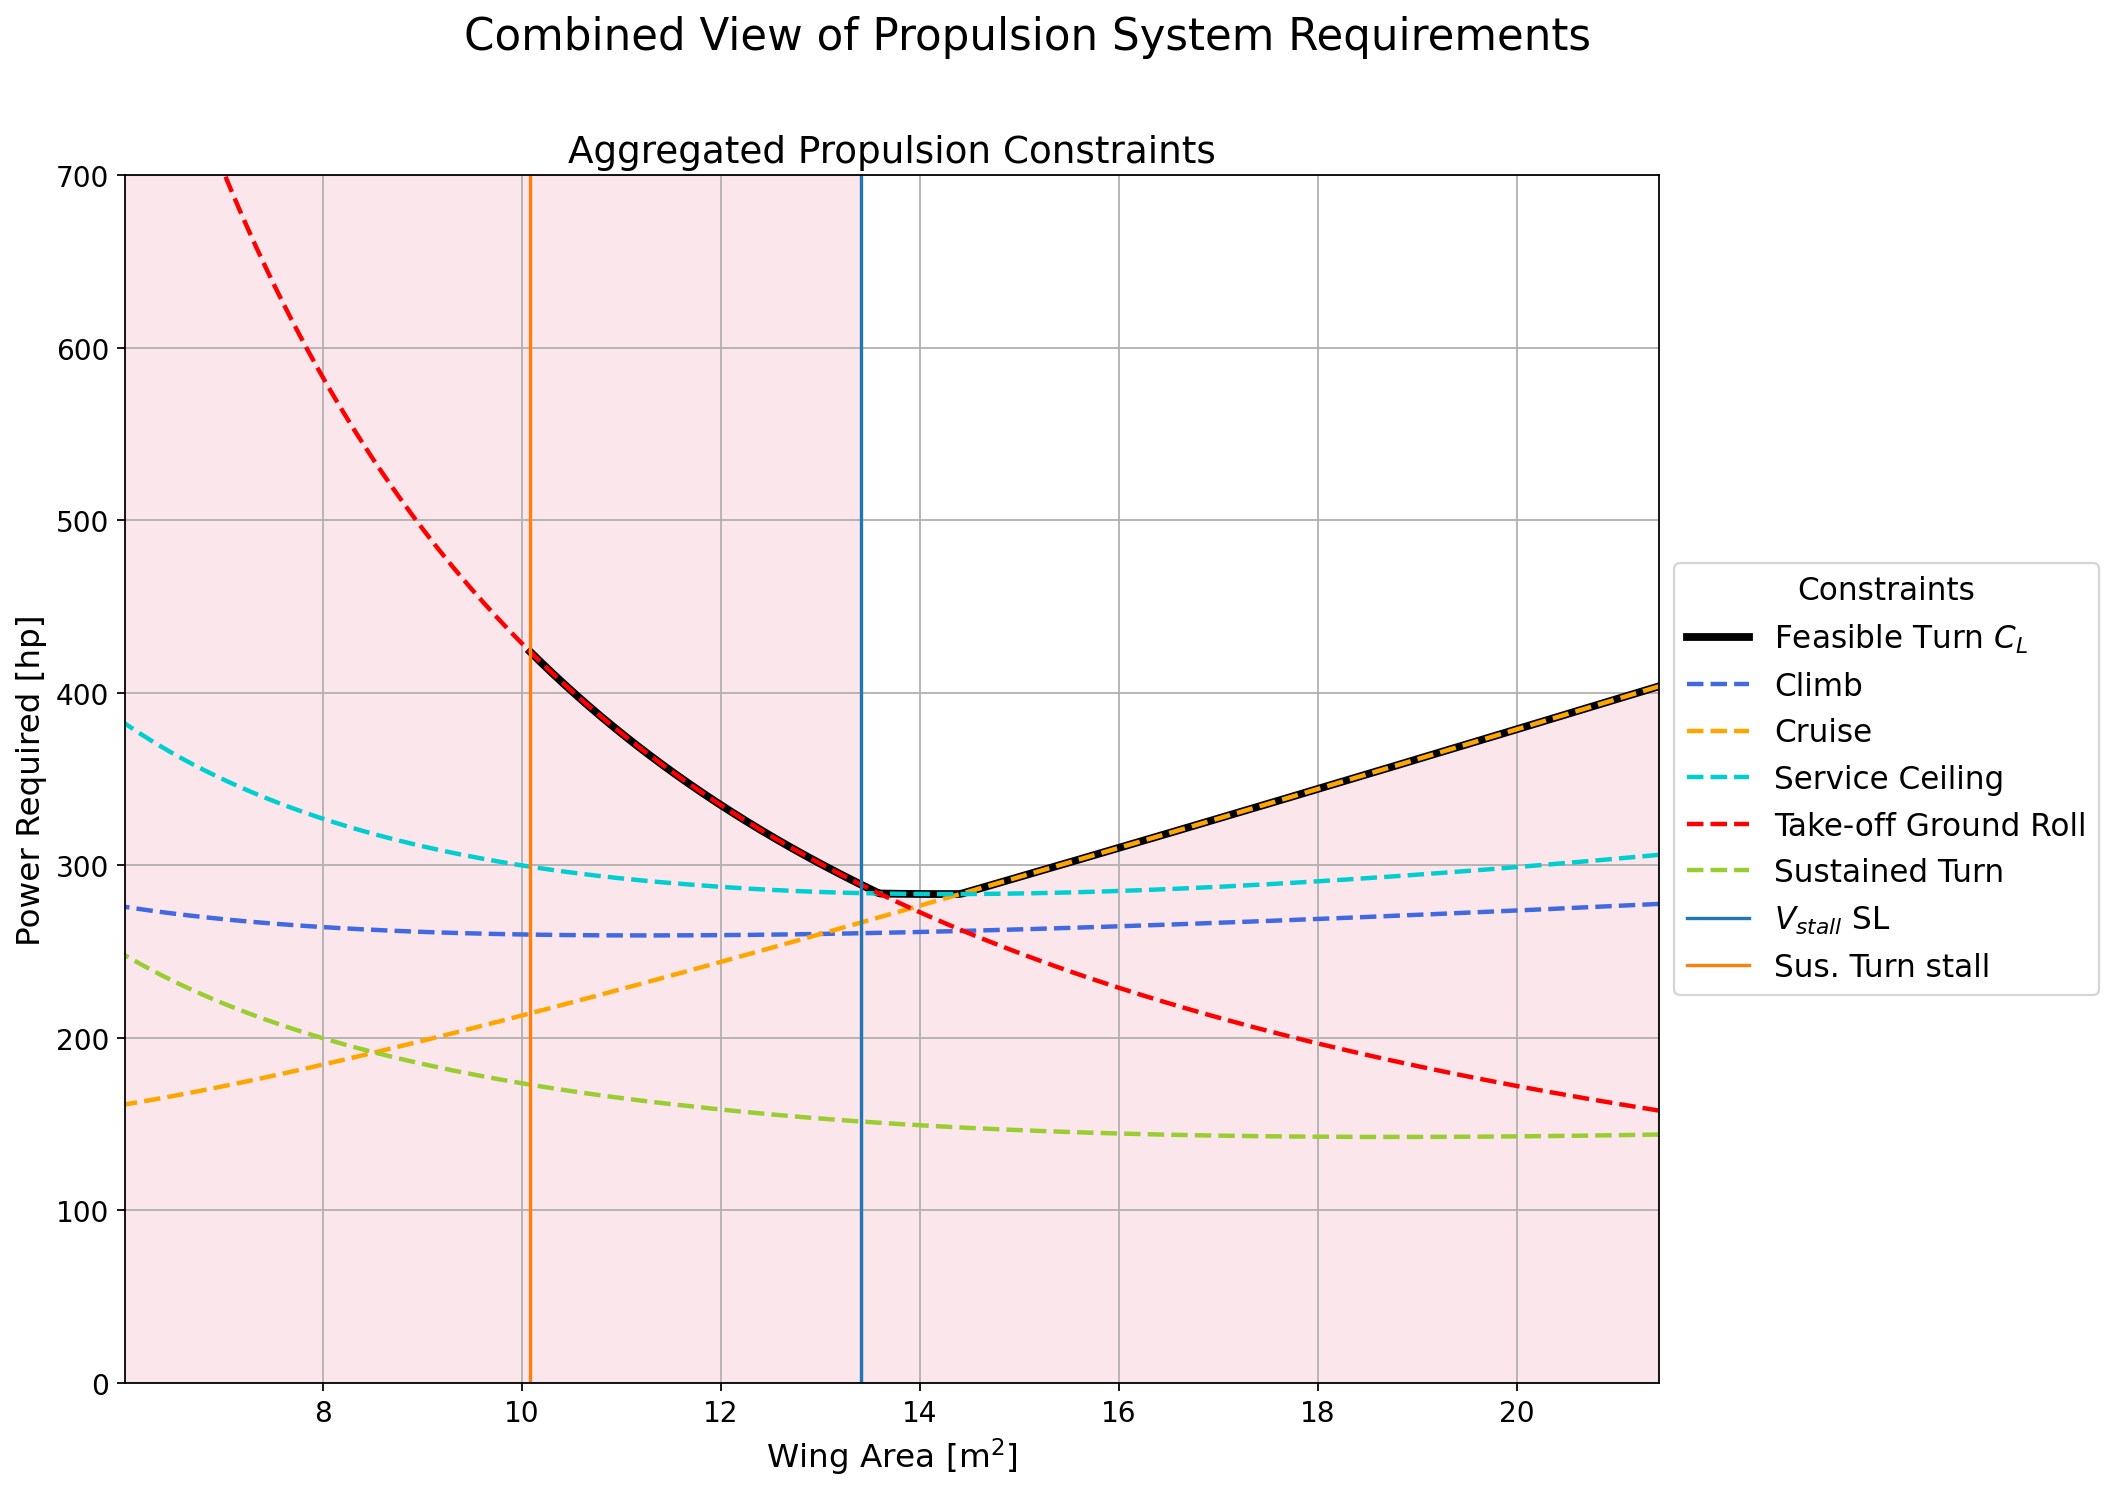

In [16]:
concept.propulsionsensitivity_monothetic(wingloading_pa=wslist_pa, show='combined', y_var='p_hp', x_var='s_m2', y_lim=700)

The aircraft concept's feasible design space is indicated by the unshaded region in the top right, bounded by the cruise, service ceiling, and sea-level stall constraints.

For our example concept, an engineer has concluded that wingloading is most favourable for the concept at a wing-area of 16 metres squared. The most powerful piston engine available to us is 300 horsepower and thus to produce a valid concept, the power requirement for cruise must be reduced.

Of all the parameters examined, the sensitivity diagram for the cruise constraint will identify the parameter that is most likely to result in the targetted power reduction. The `maskbool` argument identifies the region of wingloading for which the cruise constraint contributes to the minimum propulsion constraint:

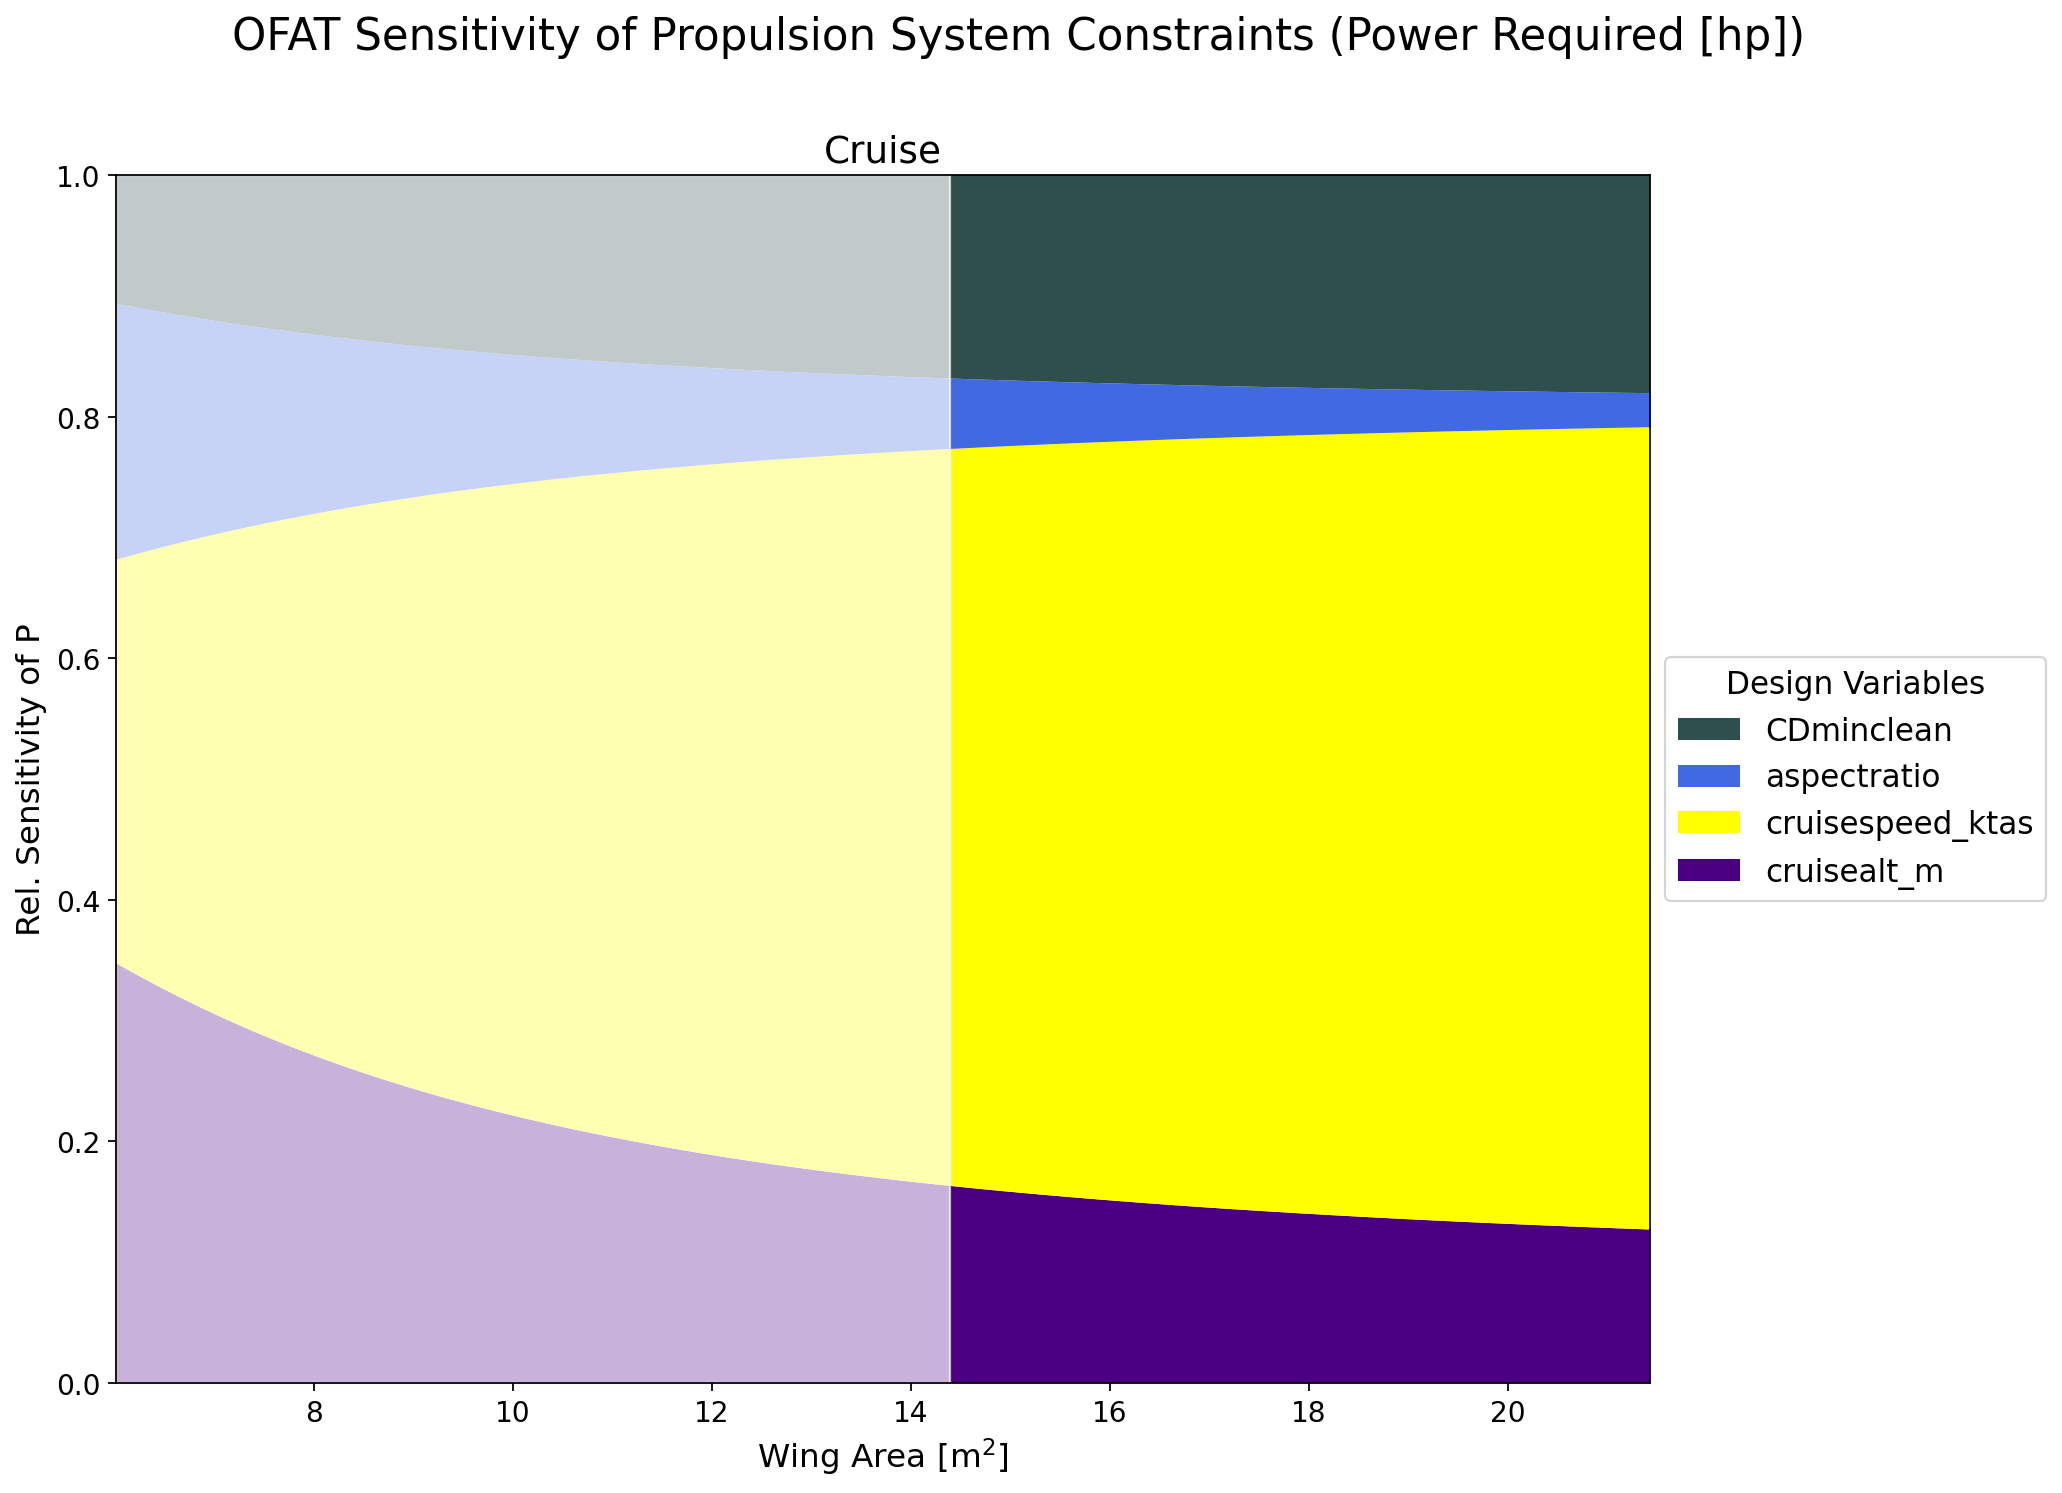

In [17]:
concept.propulsionsensitivity_monothetic(wingloading_pa=wslist_pa, show='cruise', y_var='p_hp', x_var='s_m2', maskbool=True)

The faded area on the left is ignored, and it appears the most significant changes to the constraint arise from changes to the cruisespeed, over the design ranges specified. Without knowing how power required changes with respect to cruisespeed, the best approach is to visualise the data using the `powerrequired` method:

In [18]:
designbrief = {'rwyelevation_m': 0, 'groundrun_m': 313,
                'stloadfactor': [1.5, 1.65], 'turnalt_m': [1000, 1075], 'turnspeed_ktas': [100, 110],
                'climbalt_m': 0, 'climbspeed_kias': 101, 'climbrate_fpm': 1398,
                'cruisealt_m': [2600, 3200], 'cruisespeed_ktas': [170, 175], 'cruisethrustfact': 1.0,
                'servceil_m': [6500, 6650], 'secclimbspd_kias': 92,
                'vstallclean_kcas': 69}

designdefinition = {'aspectratio': [10, 11], 'sweep_le_deg': 2, 'sweep_25_deg': 0, 'bpr': -1,
                    'weight_n': 15000,
                    'weightfractions': {'turn': 1.0, 'climb': 1.0, 'cruise': 0.853, 'servceil': 1.0}}

designperformance = {'CDTO': 0.0414, 'CLTO': 0.59, 'CLmaxTO': 1.69, 'CLmaxclean': 1.45, 'mu_R': 0.02,
                    'CDminclean': [0.0254, 0.026],
                    'etaprop': {'take-off': 0.65, 'climb': 0.8, 'cruise': 0.85, 'turn': 0.85, 'servceil': 0.8}}

designatm = at.Atmosphere()

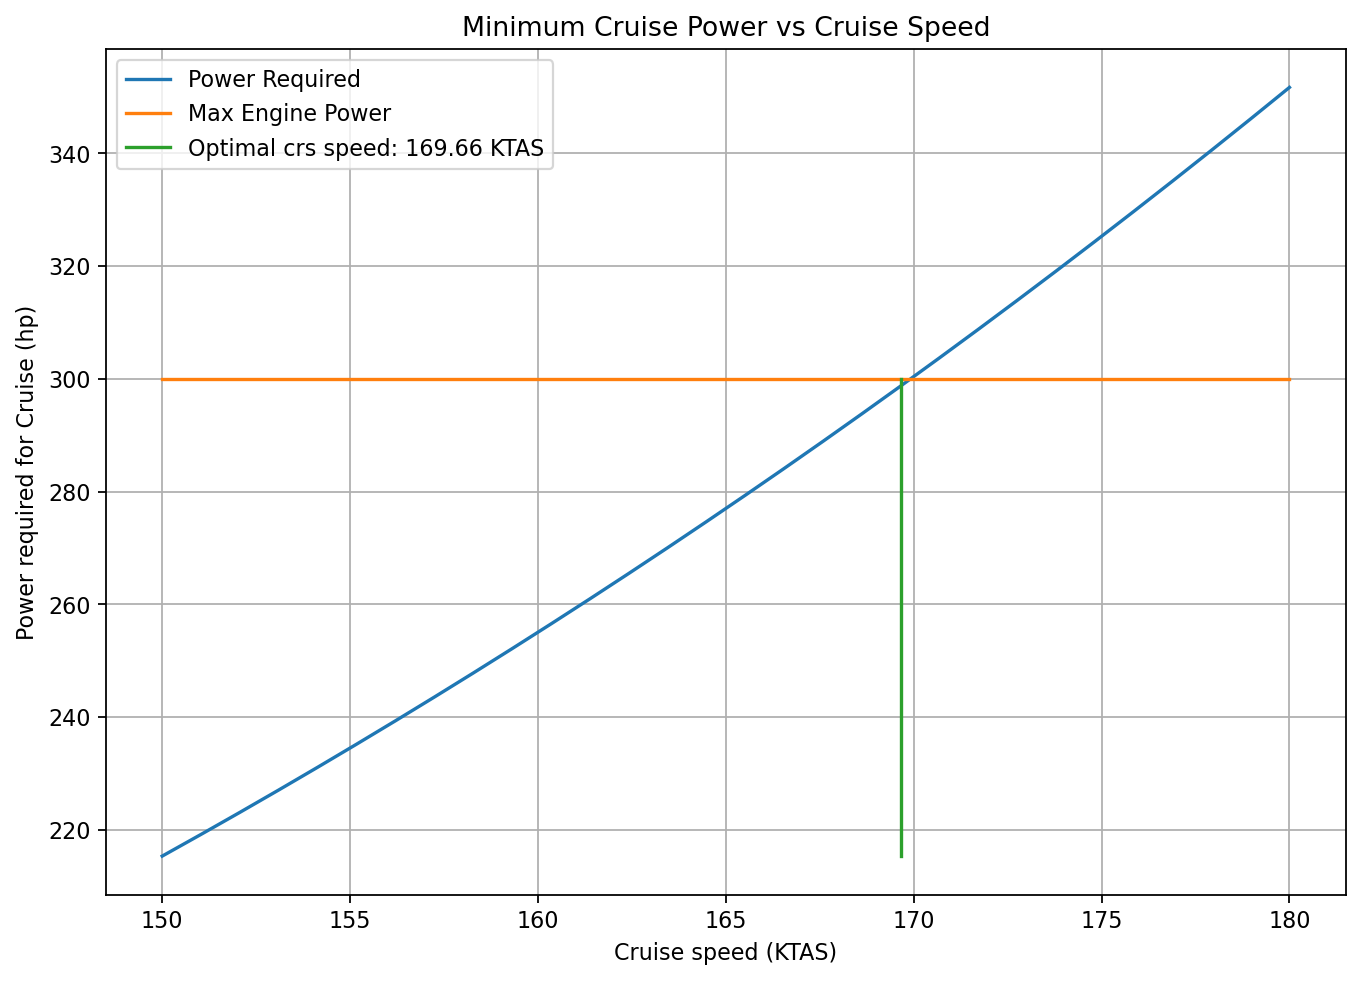

In [19]:
slist_m2 = (designdefinition['weight_n']) / (wslist_pa)

# Design search settings
starget_m2 = 16
cruiseguessmin_ktas = 150
cruiseguessmax_ktas = 180
n = 30
powertarget_hp = 300

# This is the index (idx) of the wing-loading/wing-area that gets us as close to our target wing area as possible
absolutediff = np.abs(slist_m2 - starget_m2)
starget_idx = absolutediff.argmin()

cruisespeeds_array = np.linspace(cruiseguessmin_ktas, cruiseguessmax_ktas, n)

crspower = []
for samplenumber in range(n):
    designbrief['cruisespeed_ktas'] = cruisespeeds_array[samplenumber]
    concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm)
    crspower.append(concept.powerrequired(wingloading_pa=wslist_pa, tow_kg=TOW_kg)['cruise'][starget_idx])
    
optimalcrsspeed_idx = max(np.where(crspower < np.ones(n) * powertarget_hp)[0])
optcrsspeed = round(cruisespeeds_array[optimalcrsspeed_idx], 2)
    
plt.plot(cruisespeeds_array, crspower, label='Power Required')
plt.plot([min(cruisespeeds_array), max(cruisespeeds_array)], [powertarget_hp, powertarget_hp], label='Max Engine Power')
plt.plot([optcrsspeed, optcrsspeed], [min(crspower), powertarget_hp], label='Optimal crs speed: '+ str(optcrsspeed) +' KTAS')

plt.ylabel("Power required for Cruise (hp)")
plt.xlabel("Cruise speed (KTAS)")
plt.title("Minimum Cruise Power vs Cruise Speed")
plt.legend()
plt.grid()
plt.show()

The suggested maximum cruise speed to meet the requirements of a 300 hp engine with a wing area of 16 metres squared, is 169 KTAS.